
    
**Requirements: You will need to have NLTK installed, along with downloading the corpus for stopwords. To download everything with a conda installation, run the cell below.**

In [1]:
# ONLY RUN THIS CELL IF YOU NEED 
# TO DOWNLOAD NLTK AND HAVE CONDA
# WATCH THE VIDEO FOR FULL INSTRUCTIONS ON THIS STEP

# Uncomment the code below and run:


# !conda install nltk #This installs nltk
import nltk # Imports the library
# nltk.download() #Download the necessary datasets

## Get the Data

In [2]:
import pandas as pd

In [9]:
sms = pd.read_csv('data/SMSSpamCollection', sep='\t',
                           names=["label", "text"])
sms.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [10]:
sms.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [11]:
sms.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

Let's make a new column to detect how long the text messages are:

In [13]:
sms['length'] = sms['text'].apply(len)
sms.head()

,label,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization
Let's visualize this! Let's do the imports:

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

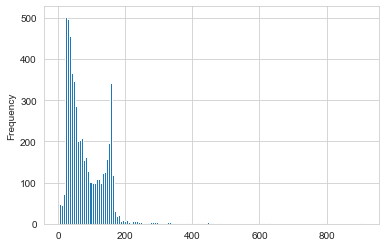

In [20]:
sms['length'].plot(bins=150, kind='hist'); 

Looks like text length may be a good feature to think about! Let's try to explain why the x-axis goes all the way to 1000ish, this must mean that there is some really long message!

In [16]:
sms.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

Woah! 910 characters, let's use masking to find this message:

In [17]:
sms[sms['length'] == 910]['text'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Looks like we have some sort of Romeo sending texts! But let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:

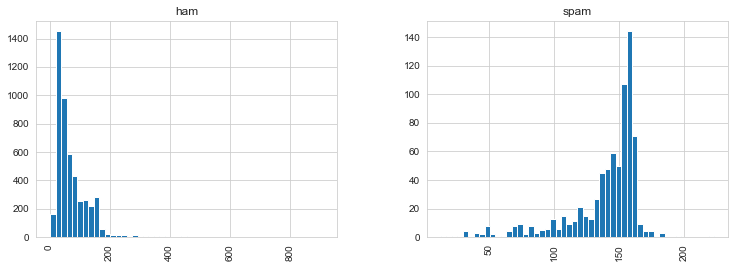

In [18]:
sms.hist(column='length', by='label', bins=50,figsize=(12,4));

Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters. (Sorry Romeo!)

## Text Pre-processing

Our main issue with our data is that it is all in text format (strings). The classification algorithms will need some sort of numerical feature vector in order to perform the classification task.There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

Now let's build a function to apply it to our DataFrame later on to do tokenization:

In [21]:
import string
from nltk.corpus import stopwords

def tokenize(mssg):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mssg if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

## Train Test Split

In [22]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(sms['text'], sms['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572). Note the default split would have been 30/70.

## Creating a Data Pipeline

Let's run our model and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [24]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=tokenize)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [25]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function tokenize at 0x7f8310e5d1e0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [28]:
predictions = pipeline.predict(msg_test)

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
print(accuracy_score(predictions,label_test))

0.9596412556053812
